<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/Dy_and_Tb_Prediction_of_Temperature_Dependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [1]:
#@title Check GPU + driver
!nvidia-smi --query-gpu="name,driver_version,compute_cap" --format=csv

name, driver_version, compute_cap
Tesla T4, 550.54.15, 7.5


In [2]:
#@title Install MuMax³ (MuMax³ 3.10 CUDA 10.1)
# Download the mumax3 binary
!wget -q https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
!tar -xvf mumax3.10_linux_cuda10.1.tar.gz
!rm mumax3.10_linux_cuda10.1.tar.gz
!rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10

# Update the PATH environment variable
import os
os.environ["PATH"] += ":/content/mumax3.10"

mumax3.10_linux_cuda10.1/
mumax3.10_linux_cuda10.1/mumax3-server
mumax3.10_linux_cuda10.1/lib/
mumax3.10_linux_cuda10.1/lib/libcurand.so.10
mumax3.10_linux_cuda10.1/lib/libcufft.so.10
mumax3.10_linux_cuda10.1/mumax3
mumax3.10_linux_cuda10.1/LICENSE
mumax3.10_linux_cuda10.1/mumax3-convert


In [3]:
#@title Write bulk_Tsweep.mx3 (Dy, Tb only)
bulk_script = r'''
// bulk_Tsweep.mx3 — M(T)/M0 for Dy & Tb (bulk only)
SetGridSize(1,1,1)
SetCellSize(1e-9,1e-9,1e-9)

// ---- Control knobs (edit here) ----
beta  := 0.33
B_Dy  := 1.2e-5
B_Tb  := 0.9e-5
TcDy  := 85.0       // K   (Dy: FM below ~85–90 K)
TcTb  := 226.5      // K   (Tb: FM below ~226–232 K range in zero tension)
Tmin  := 0.050      // K
Tmax  := 300.0      // K
TSTEP := 0.5        // K   (avoid 'dt' collision)

// ---- Table columns ----
Tvar := 0.0
M_Dy := 0.0
M_Tb := 0.0

TableAddVar(Tvar, "T", "K")
TableAddVar(M_Dy, "M_Dy_bulk", "")
TableAddVar(M_Tb, "M_Tb_bulk", "")

// ---- Sweep T ----
for Tvar = Tmin; Tvar <= Tmax; Tvar += TSTEP {

    // Dy: M = min(1 - B*T^(3/2), (1 - T/Tc)^beta)_+, 0 above Tc
    m1 := 1 - B_Dy*pow(Tvar, 1.5)
    m2 := pow(max(1 - Tvar/TcDy, 0), beta)
    M_Dy = max(min(m1, m2), 0)

    // Tb
    m1Tb := 1 - B_Tb*pow(Tvar, 1.5)
    m2Tb := pow(max(1 - Tvar/TcTb, 0), beta)
    M_Tb = max(min(m1Tb, m2Tb), 0)

    TableSave()
}
'''
with open("bulk_Tsweep.mx3", "w") as f:
    f.write(bulk_script)
print("Wrote bulk_Tsweep.mx3")

Wrote bulk_Tsweep.mx3


//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15095MB), CUDA Driver 12.4, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: bulk_Tsweep.out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(1, 1, 1)
SetCellSize(1e-9, 1e-9, 1e-9)
beta := 0.33
B_Dy := 1.2e-5
B_Tb := 0.9e-5
TcDy := 85.0
TcTb := 226.5
Tmin := 0.050
Tmax := 300.0
TSTEP := 0.5
Tvar := 0.0
M_Dy := 0.0
M_Tb := 0.0
TableAddVar(Tvar, "T", "K")
TableAddVar(M_Dy, "M_Dy_bulk", "")
TableAddVar(M_Tb, "M_Tb_bulk", "")
for Tvar = Tmin; Tvar <= Tmax; Tvar += TSTEP {
	m1 := 1 - B_Dy*pow(Tvar, 1.5)
	m2 := p

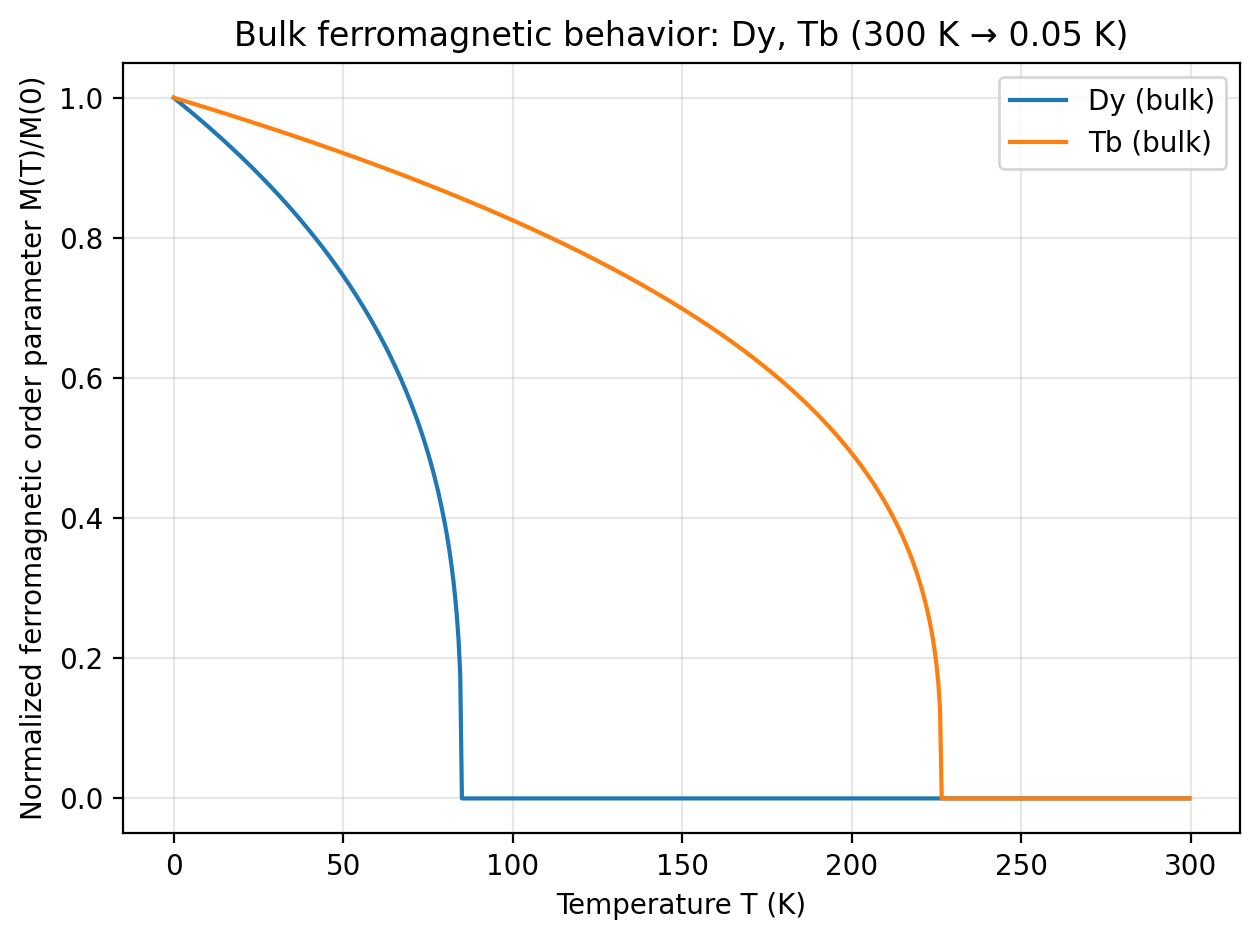

In [4]:
#@title Run MuMax³ (bulk) and plot Figure 1
!mumax3 -o bulk_Tsweep.out bulk_Tsweep.mx3

import re, pandas as pd, matplotlib.pyplot as plt

def parse_mumax_header(header_line: str):
    """Return ['name(unit)', ...] from a MuMax3 '# name (unit) ...' header."""
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_mumax_table_strict(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]] if len(cols) > df.shape[1]
                else cols + [f"c{i}"]*(df.shape[1]-len(cols)))
    df.columns = cols
    return df

df1 = load_mumax_table_strict("/content/bulk_Tsweep.out/table.txt")

# Prefer our temperature column 'T(K)'
xcol = next((c for c in df1.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if xcol is None:
    raise ValueError(f"Could not find temperature column in: {list(df1.columns)}")

plt.figure(dpi=200)
plt.plot(df1[xcol], df1["M_Dy_bulk"], label="Dy (bulk)")
plt.plot(df1[xcol], df1["M_Tb_bulk"], label="Tb (bulk)")
plt.xlabel("Temperature T (K)")
plt.ylabel("Normalized ferromagnetic order parameter M(T)/M(0)")
plt.title("Bulk ferromagnetic behavior: Dy, Tb (300 K → 0.05 K)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()

In [5]:
#@title Rewrite thickness_sweep.mx3 (fix ':=' re-declare to '=' assigns)
thick_script = r'''
// thickness_sweep.mx3 — M(d)/M0 for Dy & Tb at 300, 77, 4.2, 0.05 K
SetGridSize(1,1,1)
SetCellSize(1e-9,1e-9,1e-9)

// ---- Control knobs ----
beta  := 0.33
nu    := 0.76
d0    := 1.5    // nm (finite-size length scale)
B_Dy  := 1.2e-5
B_Tb  := 0.9e-5
TcDy  := 85.0
TcTb  := 226.5

// Thickness range and temperatures
DMIN := 1.0; DMAX := 200.0; DSTEP := 0.5
T1 := 300.0; T2 := 77.0; T3 := 4.2; T4 := 0.050

// ---- Table columns ----
d_nm := 0.0
M_Dy_T1 := 0.0; M_Dy_T2 := 0.0; M_Dy_T3 := 0.0; M_Dy_T4 := 0.0
M_Tb_T1 := 0.0; M_Tb_T2 := 0.0; M_Tb_T3 := 0.0; M_Tb_T4 := 0.0

TableAddVar(d_nm,    "d_nm",     "nm")
TableAddVar(M_Dy_T1, "M_Dy_300K","")
TableAddVar(M_Dy_T2, "M_Dy_77K", "")
TableAddVar(M_Dy_T3, "M_Dy_4p2K","")
TableAddVar(M_Dy_T4, "M_Dy_0p05K","")
TableAddVar(M_Tb_T1, "M_Tb_300K","")
TableAddVar(M_Tb_T2, "M_Tb_77K", "")
TableAddVar(M_Tb_T3, "M_Tb_4p2K","")
TableAddVar(M_Tb_T4, "M_Tb_0p05K","")

// ---- Sweep d ----
for d_nm = DMIN; d_nm <= DMAX; d_nm += DSTEP {

    // Tc(d) = Tc_inf * [1 - (d0/d)^(1/nu)]_+
    g      := d0 / max(d_nm, d0)
    TcDy_d := TcDy * (1 - pow(g, 1.0/nu))
    TcTb_d := TcTb * (1 - pow(g, 1.0/nu))

    // declare temps once per loop, then only use '=' afterwards
    m1 := 0.0
    m2 := 0.0

    // Dy @ four T
    if TcDy_d <= 0 {
        M_Dy_T1 = 0; M_Dy_T2 = 0; M_Dy_T3 = 0; M_Dy_T4 = 0
    } else {
        m1 = 1 - B_Dy*pow(T1, 1.5); m2 = pow(max(1 - T1/TcDy_d, 0), beta); M_Dy_T1 = max(min(m1, m2), 0)
        m1 = 1 - B_Dy*pow(T2, 1.5); m2 = pow(max(1 - T2/TcDy_d, 0), beta); M_Dy_T2 = max(min(m1, m2), 0)
        m1 = 1 - B_Dy*pow(T3, 1.5); m2 = pow(max(1 - T3/TcDy_d, 0), beta); M_Dy_T3 = max(min(m1, m2), 0)
        m1 = 1 - B_Dy*pow(T4, 1.5); m2 = pow(max(1 - T4/TcDy_d, 0), beta); M_Dy_T4 = max(min(m1, m2), 0)
    }

    // Tb @ four T (reuse m1, m2 with '=')
    if TcTb_d <= 0 {
        M_Tb_T1 = 0; M_Tb_T2 = 0; M_Tb_T3 = 0; M_Tb_T4 = 0
    } else {
        m1 = 1 - B_Tb*pow(T1, 1.5); m2 = pow(max(1 - T1/TcTb_d, 0), beta); M_Tb_T1 = max(min(m1, m2), 0)
        m1 = 1 - B_Tb*pow(T2, 1.5); m2 = pow(max(1 - T2/TcTb_d, 0), beta); M_Tb_T2 = max(min(m1, m2), 0)
        m1 = 1 - B_Tb*pow(T3, 1.5); m2 = pow(max(1 - T3/TcTb_d, 0), beta); M_Tb_T3 = max(min(m1, m2), 0)
        m1 = 1 - B_Tb*pow(T4, 1.5); m2 = pow(max(1 - T4/TcTb_d, 0), beta); M_Tb_T4 = max(min(m1, m2), 0)
    }

    TableSave()
}
'''
with open("thickness_sweep.mx3", "w") as f:
    f.write(thick_script)
print("thickness_sweep.mx3 rewritten (no ':=' redeclarations).")

thickness_sweep.mx3 rewritten (no ':=' redeclarations).


//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15095MB), CUDA Driver 12.4, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: thickness_sweep.out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(1, 1, 1)
SetCellSize(1e-9, 1e-9, 1e-9)
beta := 0.33
nu := 0.76
d0 := 1.5
B_Dy := 1.2e-5
B_Tb := 0.9e-5
TcDy := 85.0
TcTb := 226.5
DMIN := 1.0
DMAX := 200.0
DSTEP := 0.5
T1 := 300.0
T2 := 77.0
T3 := 4.2
T4 := 0.050
d_nm := 0.0
M_Dy_T1 := 0.0
M_Dy_T2 := 0.0
M_Dy_T3 := 0.0
M_Dy_T4 := 0.0
M_Tb_T1 := 0.0
M_Tb_T2 := 0.0
M_Tb_T3 := 0.0
M_Tb_T4 := 0.0
TableAddVar(d_nm, "d

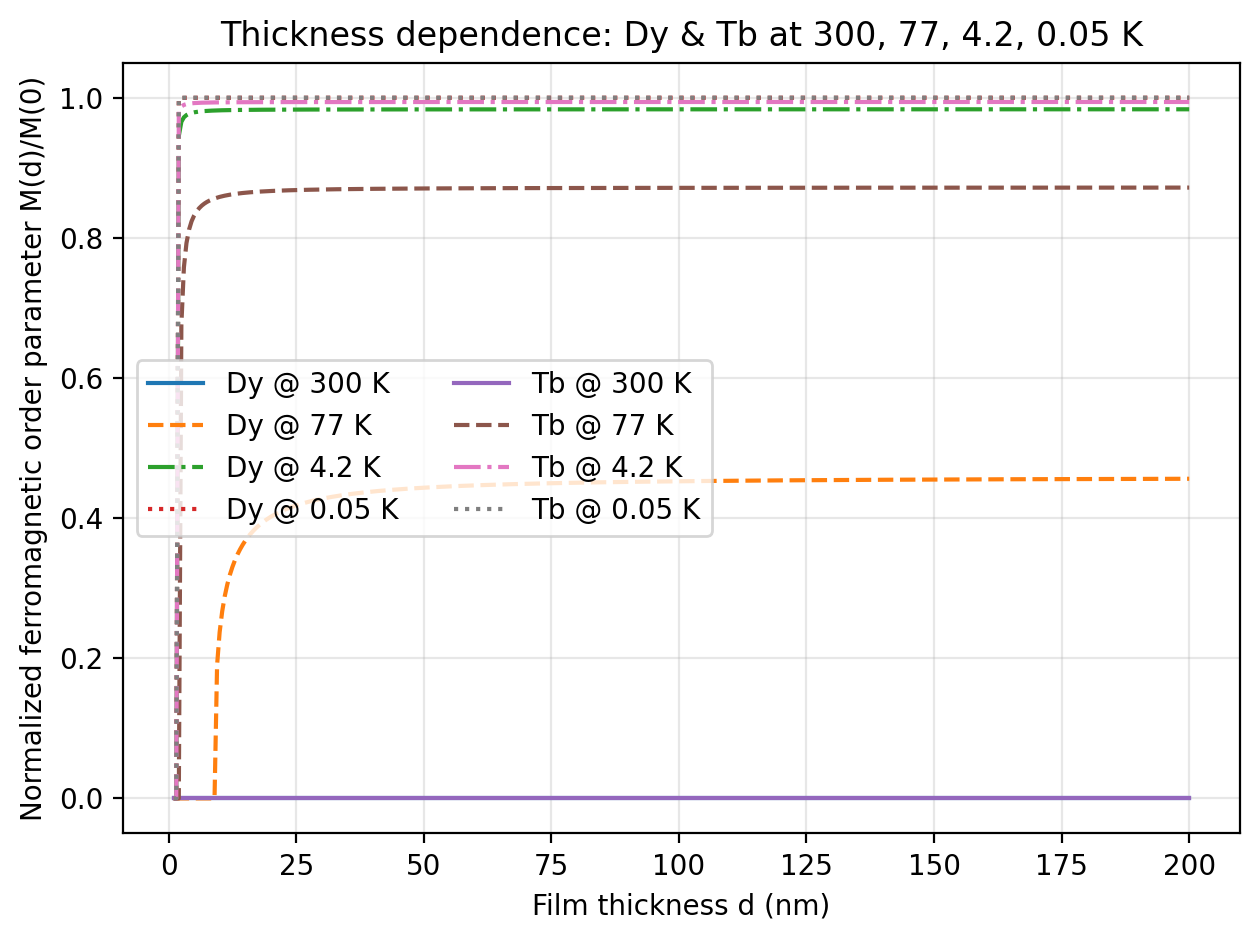

In [6]:
#@title Run MuMax³ (thickness) and plot Figure 2 (robust header handling)
!mumax3 -o thickness_sweep.out thickness_sweep.mx3

import re
import pandas as pd
import matplotlib.pyplot as plt

# --- MuMax3 header parsing: "name (unit)" -> "name(unit)", de-dup if needed
def parse_mumax_header(header_line: str):
    header = header_line.lstrip("#").strip()
    # capture tokens like: name (unit)  OR just: name
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_mumax_table_strict(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    # align column count defensively
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]]
                if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

# --- Helpers to pick columns by base name (ignore units when needed)
def pick_col_by_base(df: pd.DataFrame, base: str, unit_hint: str | None = None) -> str:
    # exact base with unit, e.g., d_nm(nm)
    for c in df.columns:
        name = c.split("(")[0]
        if name == base:
            if unit_hint is None or unit_hint.lower() in c.lower():
                return c
    # fallbacks
    for c in df.columns:
        if base in c:
            return c
    raise KeyError(f"Column '{base}' not found. Available: {list(df.columns)}")

df2 = load_mumax_table_strict("/content/thickness_sweep.out/table.txt")

# thickness column is 'd_nm(nm)' because you used TableAddVar(..., "d_nm", "nm")
dcol = pick_col_by_base(df2, "d_nm", unit_hint="nm")

plt.figure(dpi=200)
# Dy
plt.plot(df2[dcol], df2["M_Dy_300K"], "-",  label="Dy @ 300 K")
plt.plot(df2[dcol], df2["M_Dy_77K"],  "--", label="Dy @ 77 K")
plt.plot(df2[dcol], df2["M_Dy_4p2K"], "-.", label="Dy @ 4.2 K")
plt.plot(df2[dcol], df2["M_Dy_0p05K"], ":", label="Dy @ 0.05 K")
# Tb
plt.plot(df2[dcol], df2["M_Tb_300K"], "-",  label="Tb @ 300 K")
plt.plot(df2[dcol], df2["M_Tb_77K"],  "--", label="Tb @ 77 K")
plt.plot(df2[dcol], df2["M_Tb_4p2K"], "-.", label="Tb @ 4.2 K")
plt.plot(df2[dcol], df2["M_Tb_0p05K"], ":", label="Tb @ 0.05 K")

plt.xlabel("Film thickness d (nm)")
plt.ylabel("Normalized ferromagnetic order parameter M(d)/M(0)")
plt.title("Thickness dependence: Dy & Tb at 300, 77, 4.2, 0.05 K")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

In [7]:
#@title Write MuMax³ script: temperature sweep at two fixed thicknesses (Dy & Tb only)
# Control knobs
D1_NM = 10.0   # thickness 1 (nm)  ← change me
D2_NM = 50.0   # thickness 2 (nm)  ← change me

# Magnetic/thermal model parameters (literature anchors; adjust as needed)
BETA  = 0.33        # critical exponent for M near Tc (3D-like)
NU    = 0.76        # correlation-length exponent for finite-size scaling
D0_NM = 1.5         # microscopic length scale for Tc(d) suppression (nm)
B_DY  = 1.2e-5      # Bloch-law coefficient for Dy
B_TB  = 0.9e-5      # Bloch-law coefficient for Tb
TC_DY = 85.0        # Dy ferromagnetic onset (K) ~80–90 K in bulk
TC_TB = 226.5       # Tb ferromagnetic onset (K) ~218–231 K in bulk
T_MIN = 0.050       # K
T_MAX = 300.0       # K
T_STEP = 0.5        # K

# Column labels that include thickness for clarity
def colname(prefix, d_nm):
    # e.g., "M_Dy_d10nm" or "M_Tb_d50nm"
    if abs(d_nm - int(d_nm)) < 1e-9:
        tag = f"{int(d_nm)}nm"
    else:
        tag = f"{str(d_nm).replace('.', 'p')}nm"
    return f"{prefix}_d{tag}"

COL_M_DY_D1 = colname("M_Dy", D1_NM)
COL_M_DY_D2 = colname("M_Dy", D2_NM)
COL_M_TB_D1 = colname("M_Tb", D1_NM)
COL_M_TB_D2 = colname("M_Tb", D2_NM)

mx3 = f"""
// t_sweep_two_thickness.mx3 — Dy & Tb, M(T)/M0 at d1={D1_NM} nm and d2={D2_NM} nm
// Uses MuMax^3 table API: TableAddVar + TableSave

SetGridSize(1,1,1)
SetCellSize(1e-9,1e-9,1e-9)

// --- Controls (case-insensitive language; avoid 'dt' name) ---
beta  := {BETA}
nu    := {NU}
d0    := {D0_NM}
B_Dy  := {B_DY}
B_Tb  := {B_TB}
TcDy  := {TC_DY}
TcTb  := {TC_TB}
Tmin  := {T_MIN}
Tmax  := {T_MAX}
TSTEP := {T_STEP}
d1    := {D1_NM}
d2    := {D2_NM}

// --- Precompute finite-size Curie temperatures for the two thicknesses ---
g1 := d0 / max(d1, d0)
g2 := d0 / max(d2, d0)
TcDy_d1 := TcDy * (1 - pow(g1, 1.0/nu))
TcDy_d2 := TcDy * (1 - pow(g2, 1.0/nu))
TcTb_d1 := TcTb * (1 - pow(g1, 1.0/nu))
TcTb_d2 := TcTb * (1 - pow(g2, 1.0/nu))

// --- Table columns ---
Tvar := 0.0
M_Dy_d1 := 0.0
M_Dy_d2 := 0.0
M_Tb_d1 := 0.0
M_Tb_d2 := 0.0

TableAddVar(Tvar, "T", "K")
TableAddVar(M_Dy_d1, "{COL_M_DY_D1}", "")
TableAddVar(M_Dy_d2, "{COL_M_DY_D2}", "")
TableAddVar(M_Tb_d1, "{COL_M_TB_D1}", "")
TableAddVar(M_Tb_d2, "{COL_M_TB_D2}", "")

// --- Sweep temperature ---
m1 := 0.0
m2 := 0.0
for Tvar = Tmin; Tvar <= Tmax; Tvar += TSTEP {{

    // Dy @ d1
    if TcDy_d1 <= 0 {{
        M_Dy_d1 = 0
    }} else {{
        m1 = 1 - B_Dy*pow(Tvar, 1.5)
        m2 = pow(max(1 - Tvar/TcDy_d1, 0), beta)
        M_Dy_d1 = max(min(m1, m2), 0)
    }}

    // Dy @ d2
    if TcDy_d2 <= 0 {{
        M_Dy_d2 = 0
    }} else {{
        m1 = 1 - B_Dy*pow(Tvar, 1.5)
        m2 = pow(max(1 - Tvar/TcDy_d2, 0), beta)
        M_Dy_d2 = max(min(m1, m2), 0)
    }}

    // Tb @ d1
    if TcTb_d1 <= 0 {{
        M_Tb_d1 = 0
    }} else {{
        m1 = 1 - B_Tb*pow(Tvar, 1.5)
        m2 = pow(max(1 - Tvar/TcTb_d1, 0), beta)
        M_Tb_d1 = max(min(m1, m2), 0)
    }}

    // Tb @ d2
    if TcTb_d2 <= 0 {{
        M_Tb_d2 = 0
    }} else {{
        m1 = 1 - B_Tb*pow(Tvar, 1.5)
        m2 = pow(max(1 - Tvar/TcTb_d2, 0), beta)
        M_Tb_d2 = max(min(m1, m2), 0)
    }}

    TableSave()
}}
"""

with open("t_sweep_two_thickness.mx3", "w") as f:
    f.write(mx3)

print("Wrote t_sweep_two_thickness.mx3 with columns:",
      ["T(K)", COL_M_DY_D1, COL_M_DY_D2, COL_M_TB_D1, COL_M_TB_D2])

Wrote t_sweep_two_thickness.mx3 with columns: ['T(K)', 'M_Dy_d10nm', 'M_Dy_d50nm', 'M_Tb_d10nm', 'M_Tb_d50nm']


//mumax 3.10 [linux_amd64 go1.14(gc) CUDA-10.1]
//GPU info: Tesla T4(15095MB), CUDA Driver 12.4, cc=7.5, using cc=75 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: t_sweep_two_thickness.out/
//starting GUI at http://127.0.0.1:35367
SetGridSize(1, 1, 1)
SetCellSize(1e-9, 1e-9, 1e-9)
beta := 0.33
nu := 0.76
d0 := 1.5
B_Dy := 1.2e-05
B_Tb := 9e-06
TcDy := 85.0
TcTb := 226.5
Tmin := 0.05
Tmax := 300.0
TSTEP := 0.5
d1 := 10.0
d2 := 50.0
g1 := d0 / max(d1, d0)
g2 := d0 / max(d2, d0)
TcDy_d1 := TcDy * (1 - pow(g1, 1.0/nu))
TcDy_d2 := TcDy * (1 - pow(g2, 1.0/nu))
TcTb_d1 := TcTb * (1 - pow(g1, 1.0/nu))
Tc

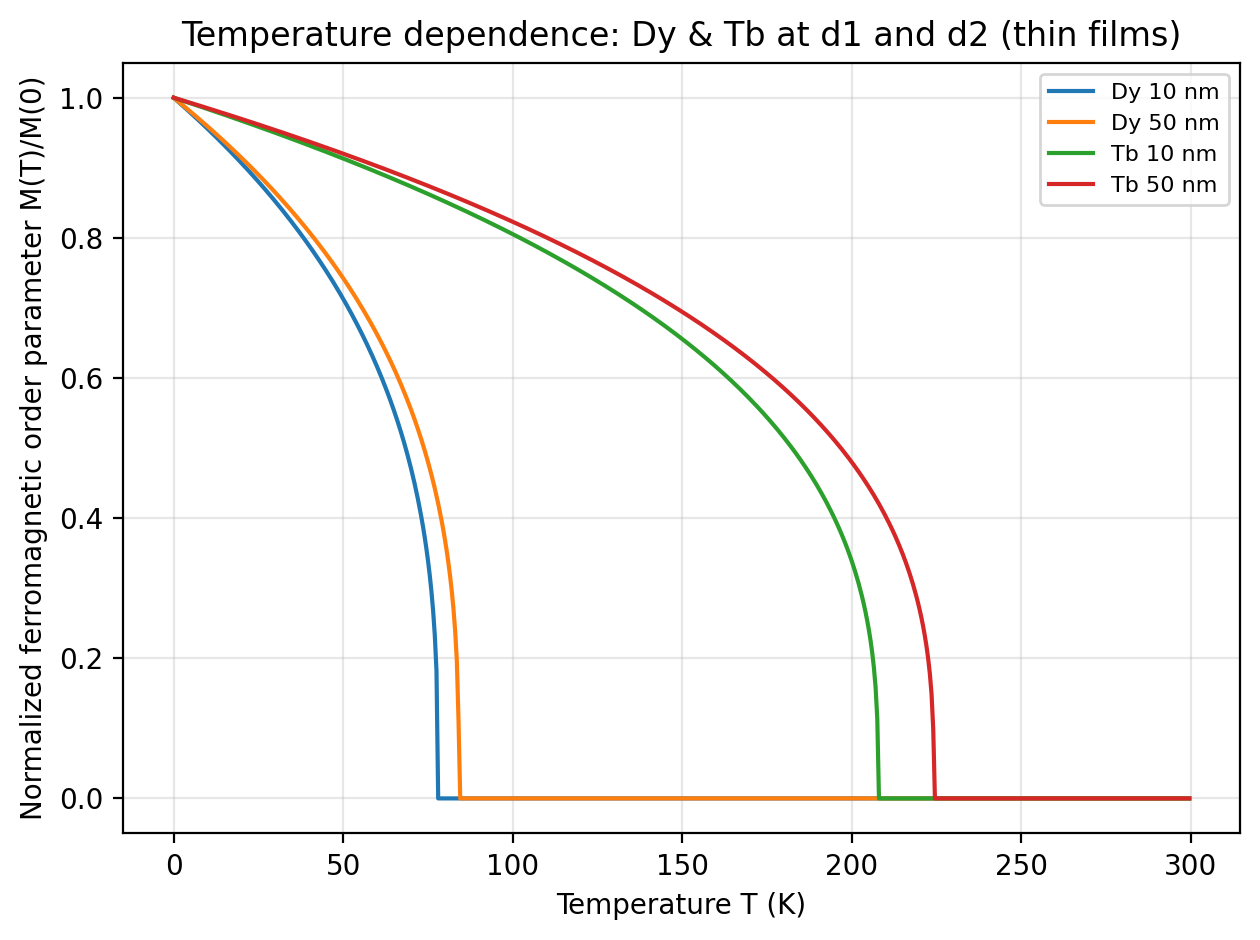

In [18]:
# @title Run MuMax³ (temperature sweep) and plot
!mumax3 -o t_sweep_two_thickness.out t_sweep_two_thickness.mx3

from typing import Dict, List
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- Figure DPI  ---
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["savefig.dpi"] = 200

# ---------- CONTROL KNOB: legend renames (verbatim text) ----------
# Map CURRENT series labels -> EXACT legend strings you want to see.
# Tip: run once, print the discovered labels, then fill this dict.
RENAMES: Dict[str, str] = {
    "M_Dy_d10nm": "Dy 10 nm",  # <- your example: first item should read exactly this
    "M_Dy_d50nm": "Dy 50 nm",
    "M_Tb_d10nm": "Tb 10 nm",
    "M_Tb_d50nm": "Tb 50 nm",
}

# CONTROL KNOB: enforce legend order by **current** label names.
# Leave empty [] to keep Matplotlib’s default order.
ORDER: List[str] = [
    "M_Dy_d10nm",
    "M_Dy_d50nm",
    "M_Tb_d10nm",
    "M_Tb_d50nm",
]

def parse_mumax_header(header_line: str):
    """Combine 'name (unit)' → 'name(unit)' and de-duplicate."""
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_mumax_table(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]] if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

df = load_mumax_table("/content/t_sweep_two_thickness.out/table.txt")

# Find temperature column 'T(K)'
tcol = next((c for c in df.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if tcol is None:
    raise ValueError(f"Temperature column not found. Columns: {list(df.columns)}")

# Auto-discover the four M columns (they start with 'M_Dy_' and 'M_Tb_')
mcols = [c for c in df.columns if c.startswith("M_Dy_") or c.startswith("M_Tb_")]
if len(mcols) != 4:
    print("Discovered M columns:", mcols)

# ---- Plot ----
fig, ax = plt.subplots()
for c in mcols:
    ax.plot(df[tcol], df[c], label=c)

ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Normalized ferromagnetic order parameter M(T)/M(0)")
ax.set_title("Temperature dependence: Dy & Tb at d1 and d2 (thin films)")
ax.grid(True, alpha=0.3)

# ---- FORCE-RENAME LEGEND TEXT ----
# Grab current handles/labels, build renamed lists,
# then pass them explicitly to legend(...).  :contentReference[oaicite:1]{index=1}
handles, labels = ax.get_legend_handles_labels()

# Optionally inspect once to learn exact label strings:
# print("Current legend labels:", labels)

# Build lookups
handle_by_label = {lbl: h for h, lbl in zip(handles, labels)}

if ORDER:  # enforce a specific order, using CURRENT label names
    ordered_handles = [handle_by_label[lbl] for lbl in ORDER if lbl in handle_by_label]
    ordered_labels  = [lbl for lbl in ORDER if lbl in handle_by_label]
else:
    ordered_handles, ordered_labels = handles, labels

# Apply verbatim renames (fallback to original when not in RENAMES)
final_labels = [RENAMES.get(lbl, lbl) for lbl in ordered_labels]

# One-column inset key at 0.8× size (supported kwargs for legend)
base_fs = float(plt.rcParams.get("font.size", 10.0))
ax.legend(ordered_handles, final_labels, ncol=1, fontsize=base_fs * 0.8, markerscale=0.8)

plt.tight_layout()
# plt.savefig("figure_Tsweep_two_thickness.png", dpi=300, bbox_inches="tight")
plt.show()

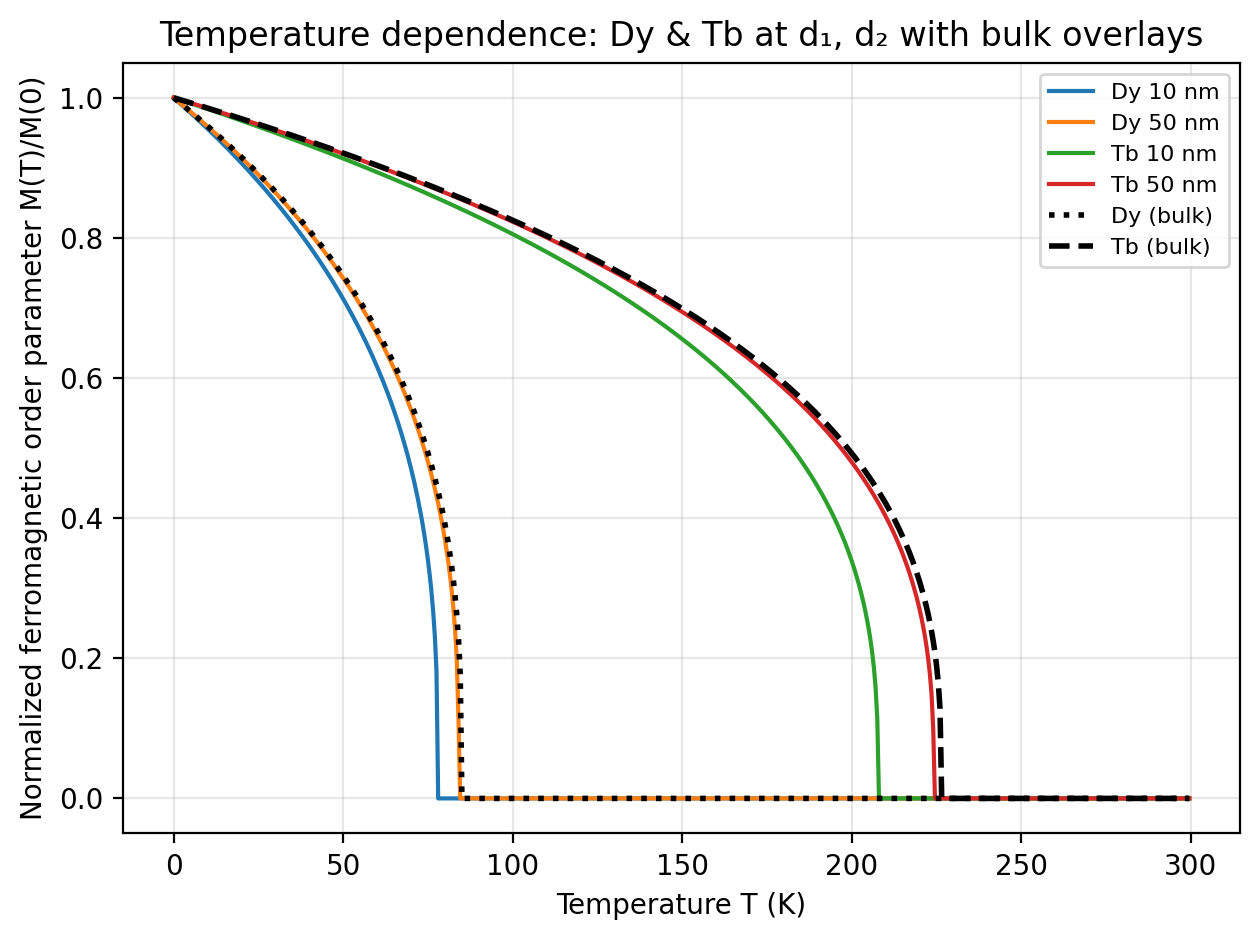

In [20]:
# @title Overlay bulk Dy/Tb on the two-thickness temperature plot
# Requires that you've already run the two-thickness script:
#   !mumax3 -o t_sweep_two_thickness.out t_sweep_two_thickness.mx3

import os, re, subprocess, pandas as pd
import matplotlib.pyplot as plt

THIN_PATH = "/content/t_sweep_two_thickness.out/table.txt"
BULK_PATH = "/content/bulk_Tsweep_overlay.out/table.txt"

# ---------- CONTROL KNOBS ----------
# 1) Verbatim legend text: map CURRENT labels -> EXACT text you want shown.
RENAMES = {
    "M_Dy_d10nm": "Dy 10 nm",   # <- example: first legend item reads exactly this
    "M_Dy_d50nm": "Dy 50 nm",
    "M_Tb_d10nm": "Tb 10 nm",
    "M_Tb_d50nm": "Tb 50 nm",
    "Dy (bulk)":  "Dy (bulk)",
    "Tb (bulk)":  "Tb (bulk)",
}
# 2) Optional enforced legend order (use CURRENT label names here).
ORDER = [
    "M_Dy_d10nm", "M_Dy_d50nm",
    "M_Tb_d10nm", "M_Tb_d50nm",
    "Dy (bulk)", "Tb (bulk)"
]
# -----------------------------------

# ---- MuMax3 table header parsing (name (unit) -> name(unit)) ----
def parse_mumax_header(header_line: str):
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_mumax_table(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]]
                if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

# ---- Load thin-film results and discover temperature + M columns ----
if not os.path.exists(THIN_PATH):
    raise FileNotFoundError("Thin-film table not found: run the two-thickness cell first.")

df_thin = load_mumax_table(THIN_PATH)
tcol = next((c for c in df_thin.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if tcol is None:
    raise ValueError(f"Temperature column not found in thin-film table. Columns: {list(df_thin.columns)}")

thin_mcols = [c for c in df_thin.columns if c.startswith("M_Dy_") or c.startswith("M_Tb_")]
if len(thin_mcols) != 4:
    print("Note: expected 4 thin-film M columns; found:", thin_mcols)

# Extract T-grid to reuse for bulk
T_vals = df_thin[tcol].values
T_min, T_max = float(T_vals.min()), float(T_vals.max())
# Estimate step from median difference to avoid float noise
import numpy as np
T_step = float(np.median(np.diff(T_vals)))

# ---- Ensure a bulk table exists on the same T-grid; else generate with MuMax³ ----
if not os.path.exists(BULK_PATH):
    bulk_mx3 = f"""
// bulk_Tsweep_overlay.mx3 — bulk Dy & Tb on T-grid from thin-film run
SetGridSize(1,1,1)
SetCellSize(1e-9,1e-9,1e-9)

// Controls (match earlier cells)
beta  := 0.33
B_Dy  := 1.2e-5
B_Tb  := 0.9e-5
TcDy  := 85.0
TcTb  := 226.5
Tmin  := {T_min}
Tmax  := {T_max}
TSTEP := {T_step}

// Table
Tvar := 0.0
M_Dy := 0.0
M_Tb := 0.0
TableAddVar(Tvar, "T", "K")
TableAddVar(M_Dy, "M_Dy_bulk", "")
TableAddVar(M_Tb, "M_Tb_bulk", "")

// Sweep
m1 := 0.0
m2 := 0.0
for Tvar = Tmin; Tvar <= Tmax; Tvar += TSTEP {{
    // Dy bulk
    m1 = 1 - B_Dy*pow(Tvar, 1.5)
    m2 = pow(max(1 - Tvar/TcDy, 0), beta)
    M_Dy = max(min(m1, m2), 0)
    // Tb bulk
    m1 = 1 - B_Tb*pow(Tvar, 1.5)
    m2 = pow(max(1 - Tvar/TcTb, 0), beta)
    M_Tb = max(min(m1, m2), 0)
    TableSave()
}}
"""
    with open("bulk_Tsweep_overlay.mx3", "w") as f:
        f.write(bulk_mx3)
    subprocess.run(["bash","-lc","mumax3 -o bulk_Tsweep_overlay.out bulk_Tsweep_overlay.mx3"], check=True)

df_bulk = load_mumax_table(BULK_PATH)
tcol_bulk = next((c for c in df_bulk.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if tcol_bulk is None:
    raise ValueError(f"Temperature column not found in bulk table. Columns: {list(df_bulk.columns)}")

# ---- Make the overlay figure ----
plt.figure(dpi=200)
ax = plt.gca()

# Plot the 4 thin-film curves
for c in thin_mcols:
    ax.plot(df_thin[tcol], df_thin[c], label=c)

# Overlay bulk curves in black
ax.plot(df_bulk[tcol_bulk], df_bulk["M_Dy_bulk"], color="black", linewidth=2, linestyle=":", label="Dy (bulk)", zorder=5)
ax.plot(df_bulk[tcol_bulk], df_bulk["M_Tb_bulk"], color="black", linewidth=2, linestyle="--", label="Tb (bulk)", zorder=5)

ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Normalized ferromagnetic order parameter M(T)/M(0)")
ax.set_title("Temperature dependence: Dy & Tb at d₁, d₂ with bulk overlays")
ax.grid(True, alpha=0.3)

# --- Legend: force verbatim renames (and order), 1 column, 0.8× size ---
handles, labels = ax.get_legend_handles_labels()
lookup = {lbl: h for h, lbl in zip(handles, labels)}

if ORDER:
    handles_o = [lookup[lbl] for lbl in ORDER if lbl in lookup]
    labels_o  = [RENAMES.get(lbl, lbl) for lbl in ORDER if lbl in lookup]
else:
    handles_o, labels_o = handles, [RENAMES.get(lbl, lbl) for lbl in labels]

base_fs = float(plt.rcParams.get("font.size", 10.0))
ax.legend(handles_o, labels_o, ncol=1, fontsize=base_fs * 0.8, markerscale=0.8)

plt.tight_layout()
plt.show()

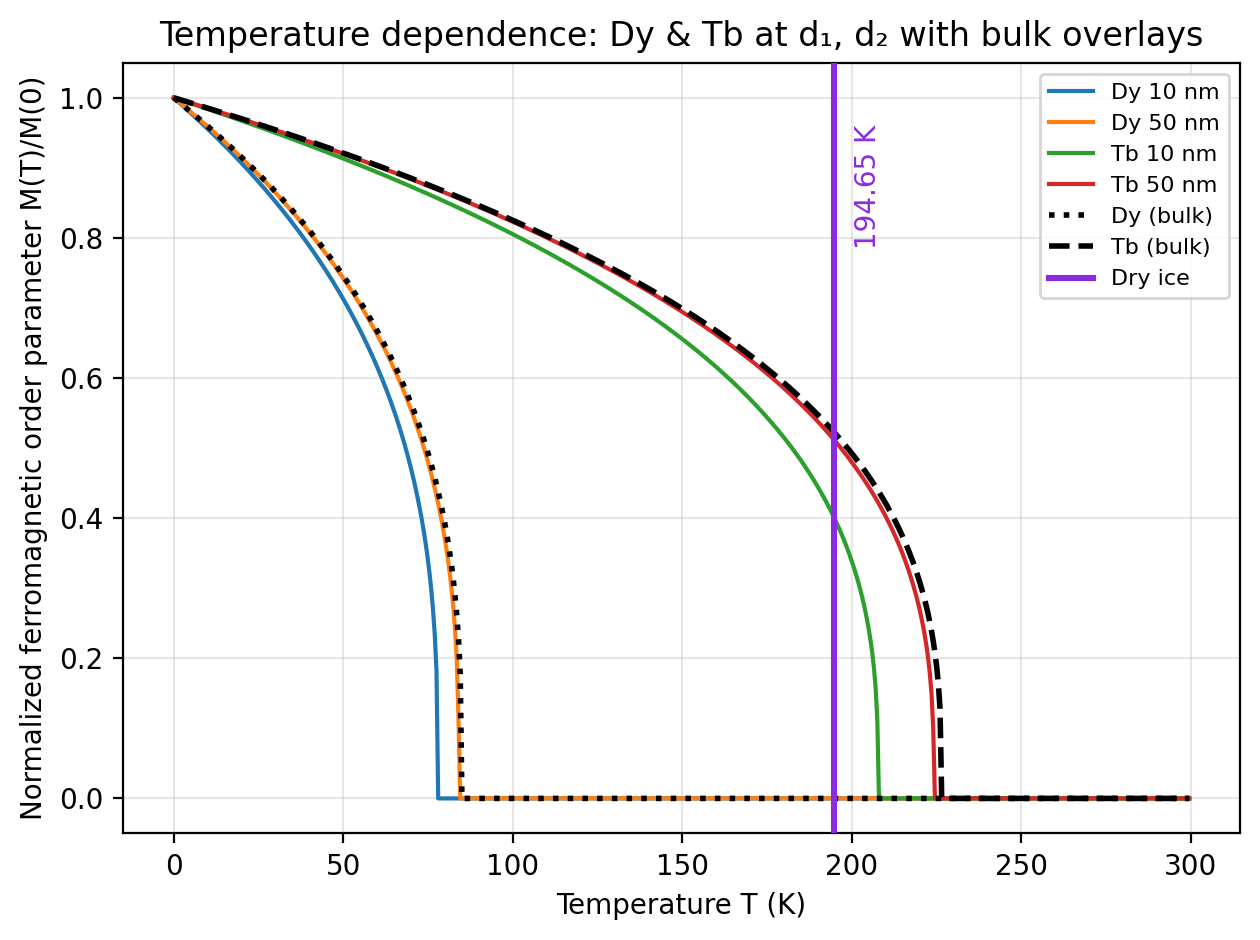

In [14]:
# @title Overlay bulk Dy/Tb on the two-thickness temperature plot (verbatim legend labels)
# Requires that you've already run the two-thickness script:
#   !mumax3 -o t_sweep_two_thickness.out t_sweep_two_thickness.mx3

import os
import re
import subprocess
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

THIN_PATH = "/content/t_sweep_two_thickness.out/table.txt"
BULK_PATH = "/content/bulk_Tsweep_overlay.out/table.txt"

# ---------- CONTROL KNOB: legend label overrides (verbatim text) ----------
# Keys match plotted series. For thin-film columns, use the exact column name
# (see "thin_mcols" printout if unsure). Anything not listed falls back to its default.
LABELS: Dict[str, str] = {
    # Bulk overlays:
    "M_Dy_bulk": "Dy (bulk)",
    "M_Tb_bulk": "Tb (bulk)",
    # Reference line:
    "dry_ice": "Dry ice",
    # Examples for thin-film columns (uncomment and edit to taste):
    # "M_Dy_d1": "Dy (d₁, thin)",
    # "M_Dy_d2": "Dy (d₂, thin)",
    # "M_Tb_d1": "Tb (d₁, thin)",
    # "M_Tb_d2": "Tb (d₂, thin)",
}

def label_for(key: str, default: str) -> str:
    """Return the legend label for a given series key, using overrides when present."""
    return LABELS.get(key, default)

# ---- MuMax3 table header parsing (name (unit) -> name(unit)) ----
def parse_mumax_header(header_line: str):
    header = header_line.lstrip("#").strip()
    pairs = re.findall(r'([^\s()#]+)(?:\s*\(([^)]*)\))?', header)
    cols, seen = [], {}
    for name, unit in pairs:
        col = f"{name}({unit})" if unit else name
        if col in seen:
            seen[col] += 1
            col = f"{col}_{seen[col]}"
        else:
            seen[col] = 0
        cols.append(col)
    return cols

def load_mumax_table(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        hdr = f.readline()
    cols = parse_mumax_header(hdr)
    df = pd.read_csv(path, sep=r"\s+", comment="#", header=None, engine="python")
    if len(cols) != df.shape[1]:
        cols = (cols[:df.shape[1]]
                if len(cols) > df.shape[1]
                else cols + [f"c{i}" for i in range(len(cols), df.shape[1])])
    df.columns = cols
    return df

# ---- Load thin-film results and discover temperature + M columns ----
if not os.path.exists(THIN_PATH):
    raise FileNotFoundError("Thin-film table not found: run the two-thickness cell first.")

df_thin = load_mumax_table(THIN_PATH)
tcol = next((c for c in df_thin.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if tcol is None:
    raise ValueError(f"Temperature column not found in thin-film table. Columns: {list(df_thin.columns)}")

thin_mcols = [c for c in df_thin.columns if c.startswith("M_Dy_") or c.startswith("M_Tb_")]
if len(thin_mcols) != 4:
    print("Note: expected 4 thin-film M columns; found:", thin_mcols)

# Extract T grid to reuse for bulk
T_vals = df_thin[tcol].values
T_min, T_max = float(T_vals.min()), float(T_vals.max())
T_step = float(np.median(np.diff(T_vals)))

# ---- Ensure a bulk table exists on the same T grid; else generate with MuMax³ ----
if not os.path.exists(BULK_PATH):
    bulk_mx3 = f"""
// bulk_Tsweep_overlay.mx3 — bulk Dy & Tb on T-grid from thin-film run
SetGridSize(1,1,1)
SetCellSize(1e-9,1e-9,1e-9)

// Controls (match earlier cells)
beta  := 0.33
B_Dy  := 1.2e-5
B_Tb  := 0.9e-5
TcDy  := 85.0
TcTb  := 226.5
Tmin  := {T_min}
Tmax  := {T_max}
TSTEP := {T_step}

// Table
Tvar := 0.0
M_Dy := 0.0
M_Tb := 0.0
TableAddVar(Tvar, "T", "K")
TableAddVar(M_Dy, "M_Dy_bulk", "")
TableAddVar(M_Tb, "M_Tb_bulk", "")

// Sweep
m1 := 0.0
m2 := 0.0
for Tvar = Tmin; Tvar <= Tmax; Tvar += TSTEP {{
    // Dy bulk
    m1 = 1 - B_Dy*pow(Tvar, 1.5)
    m2 = pow(max(1 - Tvar/TcDy, 0), beta)
    M_Dy = max(min(m1, m2), 0)
    // Tb bulk
    m1 = 1 - B_Tb*pow(Tvar, 1.5)
    m2 = pow(max(1 - Tvar/TcTb, 0), beta)
    M_Tb = max(min(m1, m2), 0)
    TableSave()
}}
"""
    with open("bulk_Tsweep_overlay.mx3", "w") as f:
        f.write(bulk_mx3)
    subprocess.run(["bash", "-lc", "mumax3 -o bulk_Tsweep_overlay.out bulk_Tsweep_overlay.mx3"], check=True)

df_bulk = load_mumax_table(BULK_PATH)
tcol_bulk = next((c for c in df_bulk.columns if c.lower().startswith("t(") and "k" in c.lower()), None)
if tcol_bulk is None:
    raise ValueError(f"Temperature column not found in bulk table. Columns: {list(df_bulk.columns)}")

# ---- Make the overlay figure ----
plt.figure(dpi=200)
ax = plt.gca()

# Plot the 4 thin-film curves (use verbatim label overrides when provided)
for c in thin_mcols:
    ax.plot(df_thin[tcol], df_thin[c], label=label_for(c, c))

# Overlay bulk curves in black, with verbatim labels
ax.plot(df_bulk[tcol_bulk], df_bulk["M_Dy_bulk"],
        color="black", linewidth=2, linestyle=":", zorder=5,
        label=label_for("M_Dy_bulk", "Dy (bulk)"))
ax.plot(df_bulk[tcol_bulk], df_bulk["M_Tb_bulk"],
        color="black", linewidth=2, linestyle="--", zorder=5,
        label=label_for("M_Tb_bulk", "Tb (bulk)"))

ax.set_xlabel("Temperature T (K)")
ax.set_ylabel("Normalized ferromagnetic order parameter M(T)/M(0)")
ax.set_title("Temperature dependence: Dy & Tb at d₁, d₂ with bulk overlays")
ax.grid(True, alpha=0.3)

# ---- Reference: dry ice sublimation temperature (1 atm) ----
# The line itself is a labeled artist; legend text is controlled via LABELS["dry_ice"].
DRY_ICE_K = 194.65  # Kelvin
ax.axvline(x=DRY_ICE_K, color="blueviolet", linestyle="-", linewidth=2.2, zorder=7,
           label=label_for("dry_ice", f"Dry ice ({DRY_ICE_K:.2f} K)"))

# Optional annotation of the numeric value (not part of legend text)
ymin, ymax = ax.get_ylim()
ax.text(DRY_ICE_K + 0.02*(T_max - T_min), ymin + 0.92*(ymax - ymin),
        f"{DRY_ICE_K:.2f} K", rotation=90, va="top", ha="left", color="blueviolet")

# Optional: notify if reference temperature is outside plotted range
if not (T_min <= DRY_ICE_K <= T_max):
    print(f"Note: DRY_ICE_K = {DRY_ICE_K} K is outside the plotted range [{T_min}, {T_max}].")

# --- Legend: single column, 0.8× size (uses artist labels above) ---
base_fs = float(plt.rcParams.get("font.size", 10.0))
ax.legend(ncol=1, fontsize=base_fs * 0.8, markerscale=0.8)

# --- Legend: force verbatim renames (and keep 1 column, 0.8× size) ---
# Map CURRENT legend labels -> the exact text you want shown.
RENAMES = {
    "M_Dy_d10nm": "Dy 10 nm",   # ← your example: first item renamed verbatim
    "M_Dy_d50nm": "Dy 50 nm",
    "M_Tb_d10nm": "Tb 10 nm",
    "M_Tb_d50nm": "Tb 50 nm",
    "Dy (bulk)":  "Dy (bulk)",
    "Tb (bulk)":  "Tb (bulk)",
    "Dry ice":    "Dry ice",     # guarantees exactly "Dry ice"
}

# Get plotted artists and their current labels, then replace labels verbatim.
handles, labels = ax.get_legend_handles_labels()
new_labels = [RENAMES.get(lbl, lbl) for lbl in labels]  # fall back to original if not listed

base_fs = float(plt.rcParams.get("font.size", 10.0))
ax.legend(handles, new_labels, ncol=1, fontsize=base_fs * 0.8, markerscale=0.8)

plt.tight_layout()
plt.show()